In [1]:
# !pip install pycountry
# !pip install folium

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import folium

# 1. Tiền xử lý dữ liệu
- Check dữ liệu trùng
- Check dữ liệu missing
- Check dữ liệu outlier

In [3]:
df = pd.read_csv('/content/drive/MyDrive/TEST DA/data.csv', encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 1.1 Check dữ liệu trùng
- Thông thường 1 đơn hàng thì mỗi sản phẩm thường sẽ chỉ xuất hiện ở 1 dòng

=> Nên các đơn hàng mà trong đó có 2 mã sản phẩm giống nhau khả năng là bị trùng

=> Để chắc chắn thì sẽ chỉ lọc bỏ các hàng giống nhau hoàn toàn ở tất cả thuộc tính

In [5]:
len(df.groupby(["InvoiceNo", 'StockCode']).filter(lambda x: len(x) > 1))

20378

In [6]:
print("Số hàng trước khi bỏ trùng: ", len(df))

df = df.drop_duplicates()
print("Số hàng sau khi bỏ trùng: ", len(df))

Số hàng trước khi bỏ trùng:  541909
Số hàng sau khi bỏ trùng:  536641


### 1.2 Check dữ liệu thiếu

In [7]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135037
Country,0


#### 1.2.1 Xử lý thiếu Description
=> Tên sản phẩm dùng để phân biệt các sản phẩm với nhau, đây là thông tin quan trọng

In [8]:
print("Có {} bị thiếu description".format(df.StockCode.nunique()))

Có 4070 bị thiếu description


In [9]:
# Check lại danh sách mã sản phẩm và tên sản phẩm, nếu có 1 sản phẩm đang có nhiều tên thì cần update lại

In [10]:
df_product = df[["StockCode",	"Description"]].drop_duplicates()
# check những sản phẩm có 2 dòng
df_product.groupby("StockCode").filter(lambda x: len(x) > 4).sort_values("StockCode")

,StockCode,Description
263884,20713,wrongly marked. 23343 in box
420390,20713,Marked as 23343
422750,20713,wrongly coded 23343
403534,20713,found
136272,20713,NaN
...,...,...
4239,85185B,PINK HORSE SOCK PUPPET
376451,85185B,PINK HORSE SOCK PUPPET KIT
345012,85185B,Found in w/hse
116406,85185B,?


In [11]:
df_product[df_product.StockCode == '20713']

,StockCode,Description
522,20713,JUMBO BAG OWLS
136272,20713,NaN
263884,20713,wrongly marked. 23343 in box
380688,20713,wrongly coded-23343
403534,20713,found
414145,20713,Found
415582,20713,wrongly marked 23343
420390,20713,Marked as 23343
422750,20713,wrongly coded 23343


In [12]:
# Có thể thấy các Sản phẩm đã bị nhập sai tên trong dữ liệu đơn hàng
# Tên đúng có vẻ là nếu nó hoàn được viết hoa
# Fill lại tên sản phẩm này bằng cách tạo 1 dict gồm key là mã SP, value là Tên viết hoa toàn bộ ký tự và dài nhất

# thay thế toàn bộ các Description Null bằng ""
df_product["Description"] = df_product["Description"].fillna("")

# thêm thuôc tính check nếu tên viết hoa toàn bộ
df_product["is_upper"] = df_product["Description"].apply(lambda x: str(x).isupper())

# thêm số ký tự của Description
df_product["len_description"] = df["Description"].apply(lambda x: len(x) if isinstance(x, str) else 0)

# sắp xếp dataframe theo thứ tự is_upper và len_description giảm dần
df_product = df_product.sort_values(["StockCode", "is_upper", "len_description"],  ascending=[True, False, False])

# Group by StockCode và lấy Đescription đầu tiên
df_product = df_product.groupby("StockCode").first().reset_index()

df_product.head()

,StockCode,Description,is_upper,len_description
0,10002,INFLATABLE POLITICAL GLOBE,True,27
1,10080,GROOVY CACTUS INFLATABLE,True,24
2,10120,DOGGY RUBBER,True,12
3,10123C,HEARTS WRAPPING TAPE,True,21
4,10123G,,False,0


In [13]:
# Tạo Dictionary Mã SP và Tên SP
dict_SKU = df_product[["StockCode",	"Description"]].set_index("StockCode").to_dict()["Description"]

In [14]:
# Thay thế tên sản phẩm trong data ban đầu
df["Description"] = df["StockCode"].apply(lambda x: dict_SKU[x])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE MOROCCAN METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### 1.2.2 Xử lý thiếu mã KH
=> Với mọi ngành nghề kinh doanh thì thông tin về KH là thông tin tối quan trọng, từ việc phân tích khách hàng, hành vi mua của Khách chúng ta có thể tìm cách tối ưu trải nghiệm khách, tạo ra các chương trình khuyến mại thích hợp để tăng sự hài lòng cho khách và từ đó tăng doanh thu

In [15]:
print(f"Có {df[df.CustomerID.isna()].InvoiceNo.nunique()} đơn hàng ko có thông tin KH")

Có 3710 đơn hàng ko có thông tin KH


In [16]:
df[df.CustomerID.isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,RETROSPOT TEA SET CERAMIC 11 PC,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [17]:
df_missing_customer = df[["InvoiceNo", "InvoiceDate", "CustomerID"]].drop_duplicates()
# Thêm thuộc tính ngày
df_missing_customer["date"] = df_missing_customer["InvoiceDate"].apply(lambda x: x.split(" ")[0])
df_missing_customer["date"] = pd.to_datetime(df_missing_customer["date"])

# thêm thuộc tính check đơn hàng thiếu mã KH
df_missing_customer["is_missing"] = df_missing_customer["CustomerID"].isna()
df_missing_customer.head(2)

,InvoiceNo,InvoiceDate,CustomerID,date,is_missing
0,536365,12/1/2010 8:26,17850.0,2010-12-01,False
7,536366,12/1/2010 8:28,17850.0,2010-12-01,False


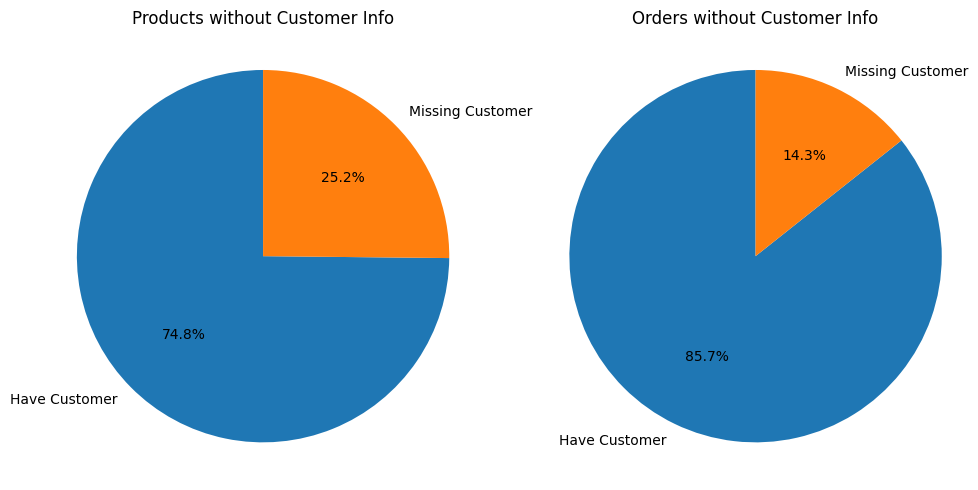

In [18]:
# Tạo subplot 1 hàng 2 cột
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Biểu đồ 1: Tỷ lệ số sản phẩm mua hàng không có thông tin khách hàng
num_products_missing_customer = len(df[df.CustomerID.isna()])
num_total_products = len(df)
sizes1 = [num_total_products - num_products_missing_customer, num_products_missing_customer]
labels1 = ['Have Customer', 'Missing Customer']
axs[0].pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=90)
axs[0].axis('equal')
axs[0].set_title('Products without Customer Info')

# Biểu đồ 2: Tỷ lệ số đơn hàng không có thông tin khách hàng
num_orders_missing_customer = df_missing_customer[df_missing_customer.is_missing]['InvoiceNo'].nunique()
num_total_orders = df_missing_customer['InvoiceNo'].nunique()
sizes2 = [num_total_orders - num_orders_missing_customer, num_orders_missing_customer]
labels2 = ['Have Customer', 'Missing Customer']
axs[1].pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=90)
axs[1].axis('equal')
axs[1].set_title('Orders without Customer Info')

plt.tight_layout()
plt.show()


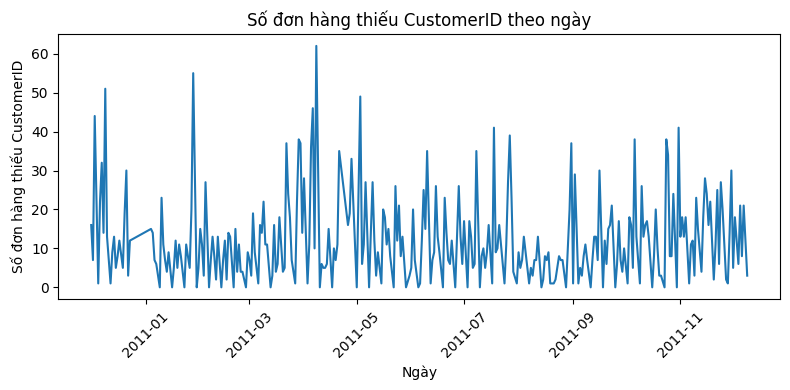

In [19]:
# Group by 'Date' and count missing orders
missing_by_date = df_missing_customer.groupby('date')['is_missing'].sum()

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(missing_by_date.index, missing_by_date.values)
plt.xlabel('Ngày')
plt.ylabel('Số đơn hàng thiếu CustomerID')
plt.title('Số đơn hàng thiếu CustomerID theo ngày')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=> Nhìn theo tổng bản ghi thì tỷ lệ ko có thông tin khách hàng chiếm 25%, tuy nhiên nếu nhìn theo cụ thể từng đơn hàng thì tỷ lệ này chỉ chiếm 15%

=> Nghĩa là những đơn hàng ko có CustomerId thì khách thường mua nhiều loại sản phẩm hơn, tại sao lại ko lấy được thông tin của những khách này: do họ không muốn tiết lộ thông tin hay do quá trình ghi dữ liệu có vấn đề

=> Và nếu nhìn theo số lượng đơn hàng ko có thông tin khách thì một số ngày bị cao hẳn lên => thì khả năng những ngày đó hệ thống có vấn đề...

### 1.3 Xử lý outlier

In [20]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,536641.000000,536641.000000,401604.000000
mean,9.620029,4.632656,15281.160818
std,219.130156,97.233118,1714.006089
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13939.000000
50%,3.000000,2.080000,15145.000000
75%,10.000000,4.130000,16784.000000
max,80995.000000,38970.000000,18287.000000


=> Số bán có trường hợp bị Min âm đến hơn -80.000 và max 80.0000

In [21]:
df[(df.Quantity == -80995.000000) | (df.Quantity == 80995.000000)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom


=> Có vẻ đơn này bị nhập sai số lượng nên ngay sau đó đã sửa lại bằng cách tạo một đơn mới để trừ đi số đó

=> Hóa đơn có ký hiệu chữ "C" => cần check thêm các kiểu hóa đơn khác

=> Cũng tồn tại nhiều đơn có số lượng âm => đều là những đơn trả hàng

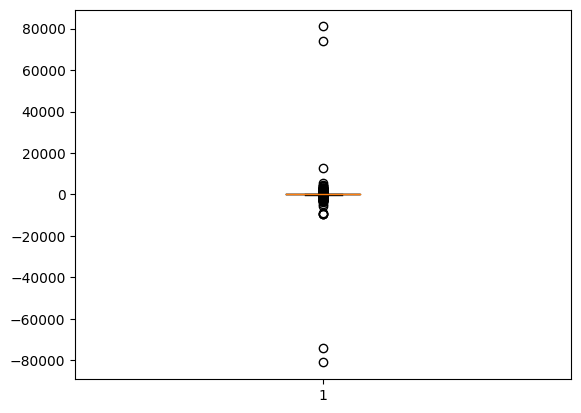

In [22]:
plt.boxplot(df['Quantity'])
plt.show()

In [23]:
def remove_outliers(df, column_name, iqr_multiplier = 2):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr
    df = df[(df[column_name] >= lower_bound) & \
            (df[column_name] <= upper_bound)]
    return df

df = remove_outliers(df, 'Quantity')
df = remove_outliers(df, 'UnitPrice')

<ipython-input-24-6796ef244c2b>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Quantity'], ax=axs[1])


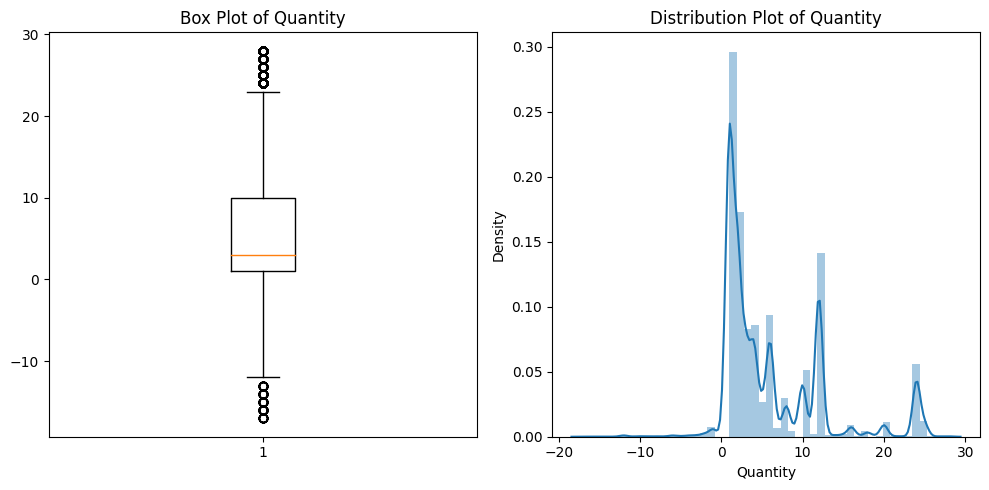

In [24]:
# Tạo subplot 1 hàng 2 cột
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Vẽ box plot trên subplot đầu tiên
axs[0].boxplot(df['Quantity'])
axs[0].set_title('Box Plot of Quantity')

# Vẽ dist plot trên subplot thứ hai
sns.distplot(df['Quantity'], ax=axs[1])
axs[1].set_title('Distribution Plot of Quantity')

plt.tight_layout()
plt.show()


# 2. Phân tích các key metrics
- Số lượng đơn hàng
- Doanh thu
- Doanh thu và số bán theo sản phẩm
- Doanh thu và số bán theo quốc gia
- Thời gian cao điểm trong ngày, tuần, năm
- Top Khách hàng
- RFM Analysis

In [25]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["hour"] = df["InvoiceDate"].dt.hour
df["dayofweek"] = df["InvoiceDate"].dt.dayofweek + 2

df["year_month"] = df["InvoiceDate"].dt.strftime('%Y-%m')
df["year_month_day"] = df["InvoiceDate"].dt.strftime('%Y-%m-%d')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,dayofweek,year_month,year_month_day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,4,2010-12,2010-12-01
1,536365,71053,WHITE MOROCCAN METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,4,2010-12,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,4,2010-12,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,4,2010-12,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,4,2010-12,2010-12-01


In [26]:
df_sale = df.copy()

In [27]:
df_sale["revenue"] = df_sale["Quantity"] * df_sale["UnitPrice"]
df_sale.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,dayofweek,year_month,year_month_day,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,4,2010-12,2010-12-01,15.30
1,536365,71053,WHITE MOROCCAN METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,4,2010-12,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,4,2010-12,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,4,2010-12,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,4,2010-12,2010-12-01,20.34


#### 2.1 số lượng đơn hàng theo giờ, ngày, tháng

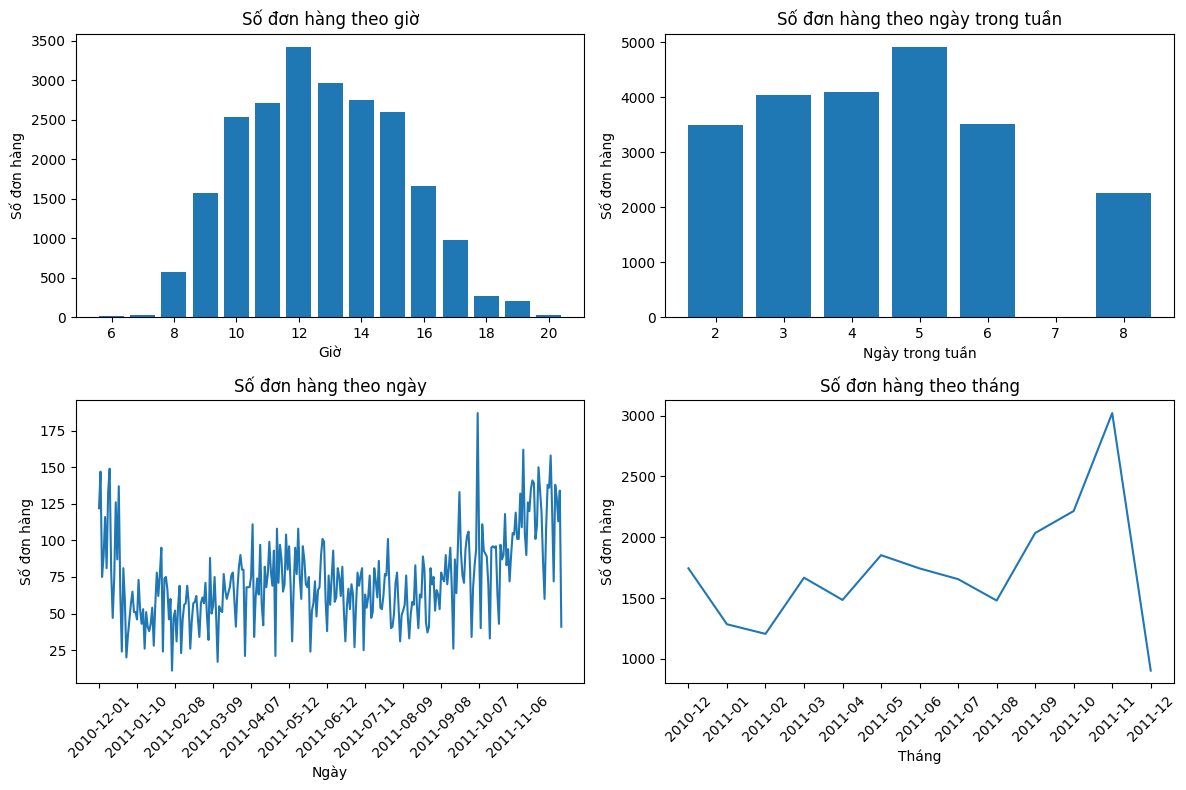

In [28]:
# Tạo subplot 2 hàng 2 cột
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Biểu đồ 1: Doanh thu theo giờ
revenue_by_hour = df_sale.groupby('hour')['InvoiceNo'].nunique()
axs[0, 0].bar(revenue_by_hour.index, revenue_by_hour.values)
axs[0, 0].set_xlabel('Giờ')
axs[0, 0].set_ylabel('Số đơn hàng')
axs[0, 0].set_title('Số đơn hàng theo giờ')

# Biểu đồ 2: Doanh thu theo ngày trong tuần
revenue_by_dayofweek = df_sale.groupby('dayofweek')['InvoiceNo'].nunique()
axs[0, 1].bar(revenue_by_dayofweek.index, revenue_by_dayofweek.values)
axs[0, 1].set_xlabel('Ngày trong tuần')
axs[0, 1].set_ylabel('Số đơn hàng')
axs[0, 1].set_title('Số đơn hàng theo ngày trong tuần')

# Biểu đồ 3: Doanh thu theo ngày
revenue_by_year_month_day = df_sale.groupby('year_month_day')['InvoiceNo'].nunique()
axs[1, 0].plot(revenue_by_year_month_day.index, revenue_by_year_month_day.values)

num_labels = 12
step = len(revenue_by_year_month_day) // num_labels
positions = [i * step for i in range(num_labels)]
labels = [revenue_by_year_month_day.index[i] for i in positions]

axs[1, 0].set_xlabel('Ngày')
axs[1, 0].set_ylabel('Số đơn hàng')
axs[1, 0].set_title('Số đơn hàng theo ngày')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].set_xticks(positions)
axs[1, 0].set_xticklabels(labels)

# Biểu đồ 4: Doanh thu theo tháng
revenue_by_year_month = df_sale.groupby('year_month')['InvoiceNo'].nunique()
axs[1, 1].plot(revenue_by_year_month.index, revenue_by_year_month.values)
axs[1, 1].set_xlabel('Tháng')
axs[1, 1].set_ylabel('Số đơn hàng')
axs[1, 1].set_title('Số đơn hàng theo tháng')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### 2.2 Doanh thu theo giờ, ngày, tháng

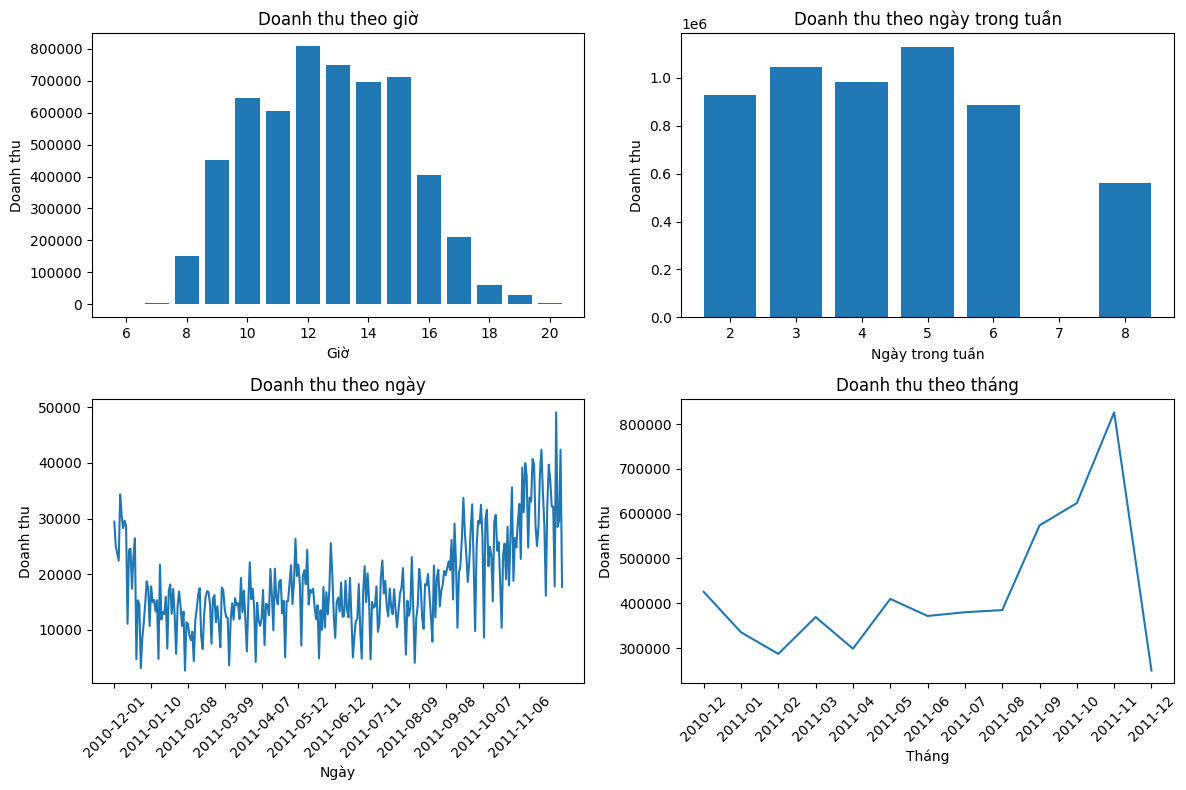

In [29]:
# Tạo subplot 2 hàng 2 cột
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Biểu đồ 1: Doanh thu theo giờ
revenue_by_hour = df_sale.groupby('hour')['revenue'].sum()
axs[0, 0].bar(revenue_by_hour.index, revenue_by_hour.values)
axs[0, 0].set_xlabel('Giờ')
axs[0, 0].set_ylabel('Doanh thu')
axs[0, 0].set_title('Doanh thu theo giờ')

# Biểu đồ 2: Doanh thu theo ngày trong tuần
revenue_by_dayofweek = df_sale.groupby('dayofweek')['revenue'].sum()
axs[0, 1].bar(revenue_by_dayofweek.index, revenue_by_dayofweek.values)
axs[0, 1].set_xlabel('Ngày trong tuần')
axs[0, 1].set_ylabel('Doanh thu')
axs[0, 1].set_title('Doanh thu theo ngày trong tuần')

# Biểu đồ 3: Doanh thu theo ngày
revenue_by_year_month_day = df_sale.groupby('year_month_day')['revenue'].sum()
axs[1, 0].plot(revenue_by_year_month_day.index, revenue_by_year_month_day.values)

num_labels = 12
step = len(revenue_by_year_month_day) // num_labels
positions = [i * step for i in range(num_labels)]
labels = [revenue_by_year_month_day.index[i] for i in positions]

axs[1, 0].set_xlabel('Ngày')
axs[1, 0].set_ylabel('Doanh thu')
axs[1, 0].set_title('Doanh thu theo ngày')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].set_xticks(positions)
axs[1, 0].set_xticklabels(labels)

# Biểu đồ 4: Doanh thu theo tháng
revenue_by_year_month = df_sale.groupby('year_month')['revenue'].sum()
axs[1, 1].plot(revenue_by_year_month.index, revenue_by_year_month.values)
axs[1, 1].set_xlabel('Tháng')
axs[1, 1].set_ylabel('Doanh thu')
axs[1, 1].set_title('Doanh thu theo tháng')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## => Nhìn vào biều đồ trên có thể thấy:
 - Doanh thu cửa hàng sẽ tập trung cao điểm từ 10-15h hàng ngày, cao nhất là trong khoảng 12h
    + thông thường ngta sẽ có xu hướng mua vào buổi chiều tối hơn vì giờ đó tan ca làm việc, nhưng với bộ dữ liệu này khách mua buổi tối rất ít
    + dữ liệu này có ảnh hướng do múi giờ không => cần check thêm
 - Các ngày thứ 7 hoàn toàn bị thiếu dữ liệu => vấn đề nghiêm trọng cần check lại nguồn dữ liệu này
 - Xu hướng doanh thu cũng đang tăng trưởng, đặc biệt tăng cao từ giai đoạn tháng 9/2011 đến tháng 11/2021, tuy nhiên đến tháng 12/2011 thì lại chưa có dữ liệu
    + -> căn cứ theo số liệu tháng 12/2010 thì khả năng tháng 12/2011 doanh thu sẽ tiếp tục tăng cao => cho thấy xu hướng mua hàng tập trung chủ yếu vào các dịp cuối năm

#### 2.3 Doanh thu theo quốc gia

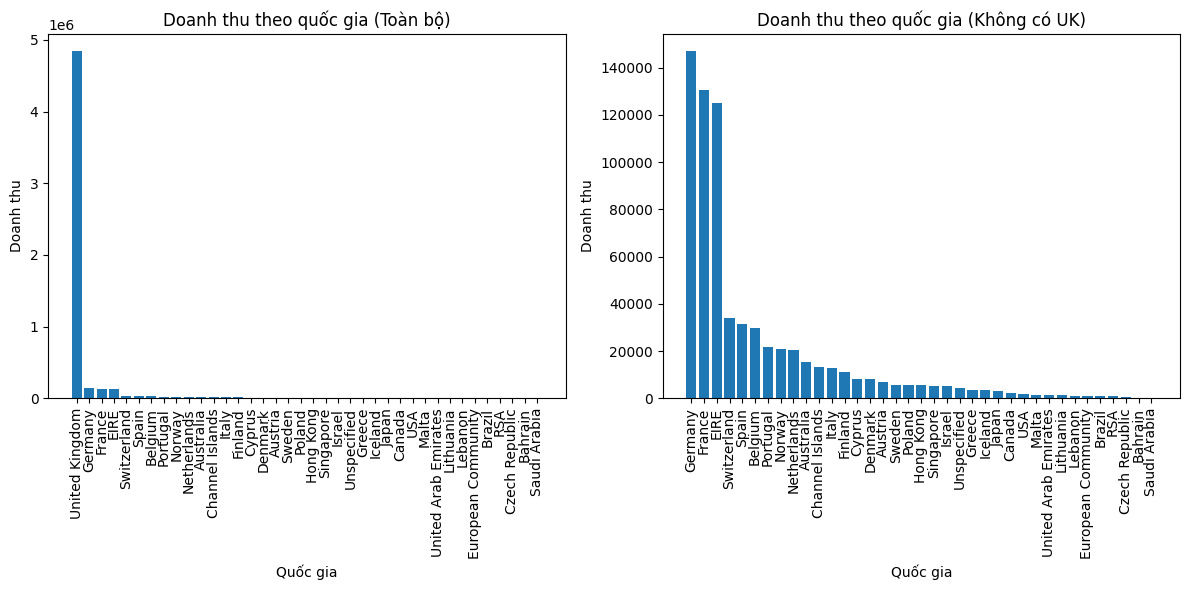

In [30]:
# Tạo subplot 1 hàng 2 cột
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ 1: Doanh thu theo quốc gia (toàn bộ)
revenue_by_country = df_sale.groupby('Country')['revenue'].sum().sort_values(ascending=False)
axs[0].bar(revenue_by_country.index, revenue_by_country.values)
axs[0].set_xlabel('Quốc gia')
axs[0].set_ylabel('Doanh thu')
axs[0].set_title('Doanh thu theo quốc gia (Toàn bộ)')
axs[0].tick_params(axis='x', rotation=90)

# Biểu đồ 2: Doanh thu theo quốc gia (không có Anh)
revenue_by_country_without_uk = revenue_by_country.drop('United Kingdom')
axs[1].bar(revenue_by_country_without_uk.index, revenue_by_country_without_uk.values)
axs[1].set_xlabel('Quốc gia')
axs[1].set_ylabel('Doanh thu')
axs[1].set_title('Doanh thu theo quốc gia (Không có UK)')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [31]:
revenue_by_country.head()

,revenue
Country,
United Kingdom,4843865.644
Germany,146995.100
France,130717.590
EIRE,125118.150
Switzerland,34057.530


In [32]:
def get_country_code(country_name):
    if country_name == 'EIRE':
        return 'IRL'
    elif country_name == 'RSA':
        return 'RUS'
    elif country_name == 'USA':
        return 'USA'
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_3
    except:
        return 'Unknown'

revenue_by_country =revenue_by_country.reset_index()
revenue_by_country['country_code'] = revenue_by_country['Country'].apply(get_country_code)
revenue_by_country = revenue_by_country[revenue_by_country["country_code"] != 'Unknown']
revenue_by_country.head()

,Country,revenue,country_code
0,United Kingdom,4843865.644,GBR
1,Germany,146995.100,DEU
2,France,130717.590,FRA
3,EIRE,125118.150,IRL
4,Switzerland,34057.530,CHE


In [33]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'

In [34]:
m_exclude_uk = folium.Map(location=[54.38927808402508, -2.34759020108484], zoom_start=2)

cp = folium.Choropleth(
    geo_data=country_shapes,
    name="choropleth",
    data=revenue_by_country[revenue_by_country.Country != 'United Kingdom'],
    columns=["country_code", "revenue"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Doanh thu không tính United Kingdom",
).add_to(m_exclude_uk)

# creating a state indexed version of the dataframe so we can lookup values
data_revenue = revenue_by_country.set_index('country_code')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    if s['id'] in data_revenue.index:
        s['properties']['revenue'] = data_revenue.loc[s['id'], 'revenue']
    else:
        s['properties']['revenue'] = 0
# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['name', 'revenue']).add_to(cp.geojson)


folium.LayerControl().add_to(m_exclude_uk)

m_exclude_uk

Bên ngoài UK thì doanh thu phần lớn vẫn đến từ các quốc gia châu ÂU khác, cụ thể có Ireland, Hà Lan, Pháp.. Đức.
Ngoài châu Âu thì có Úc

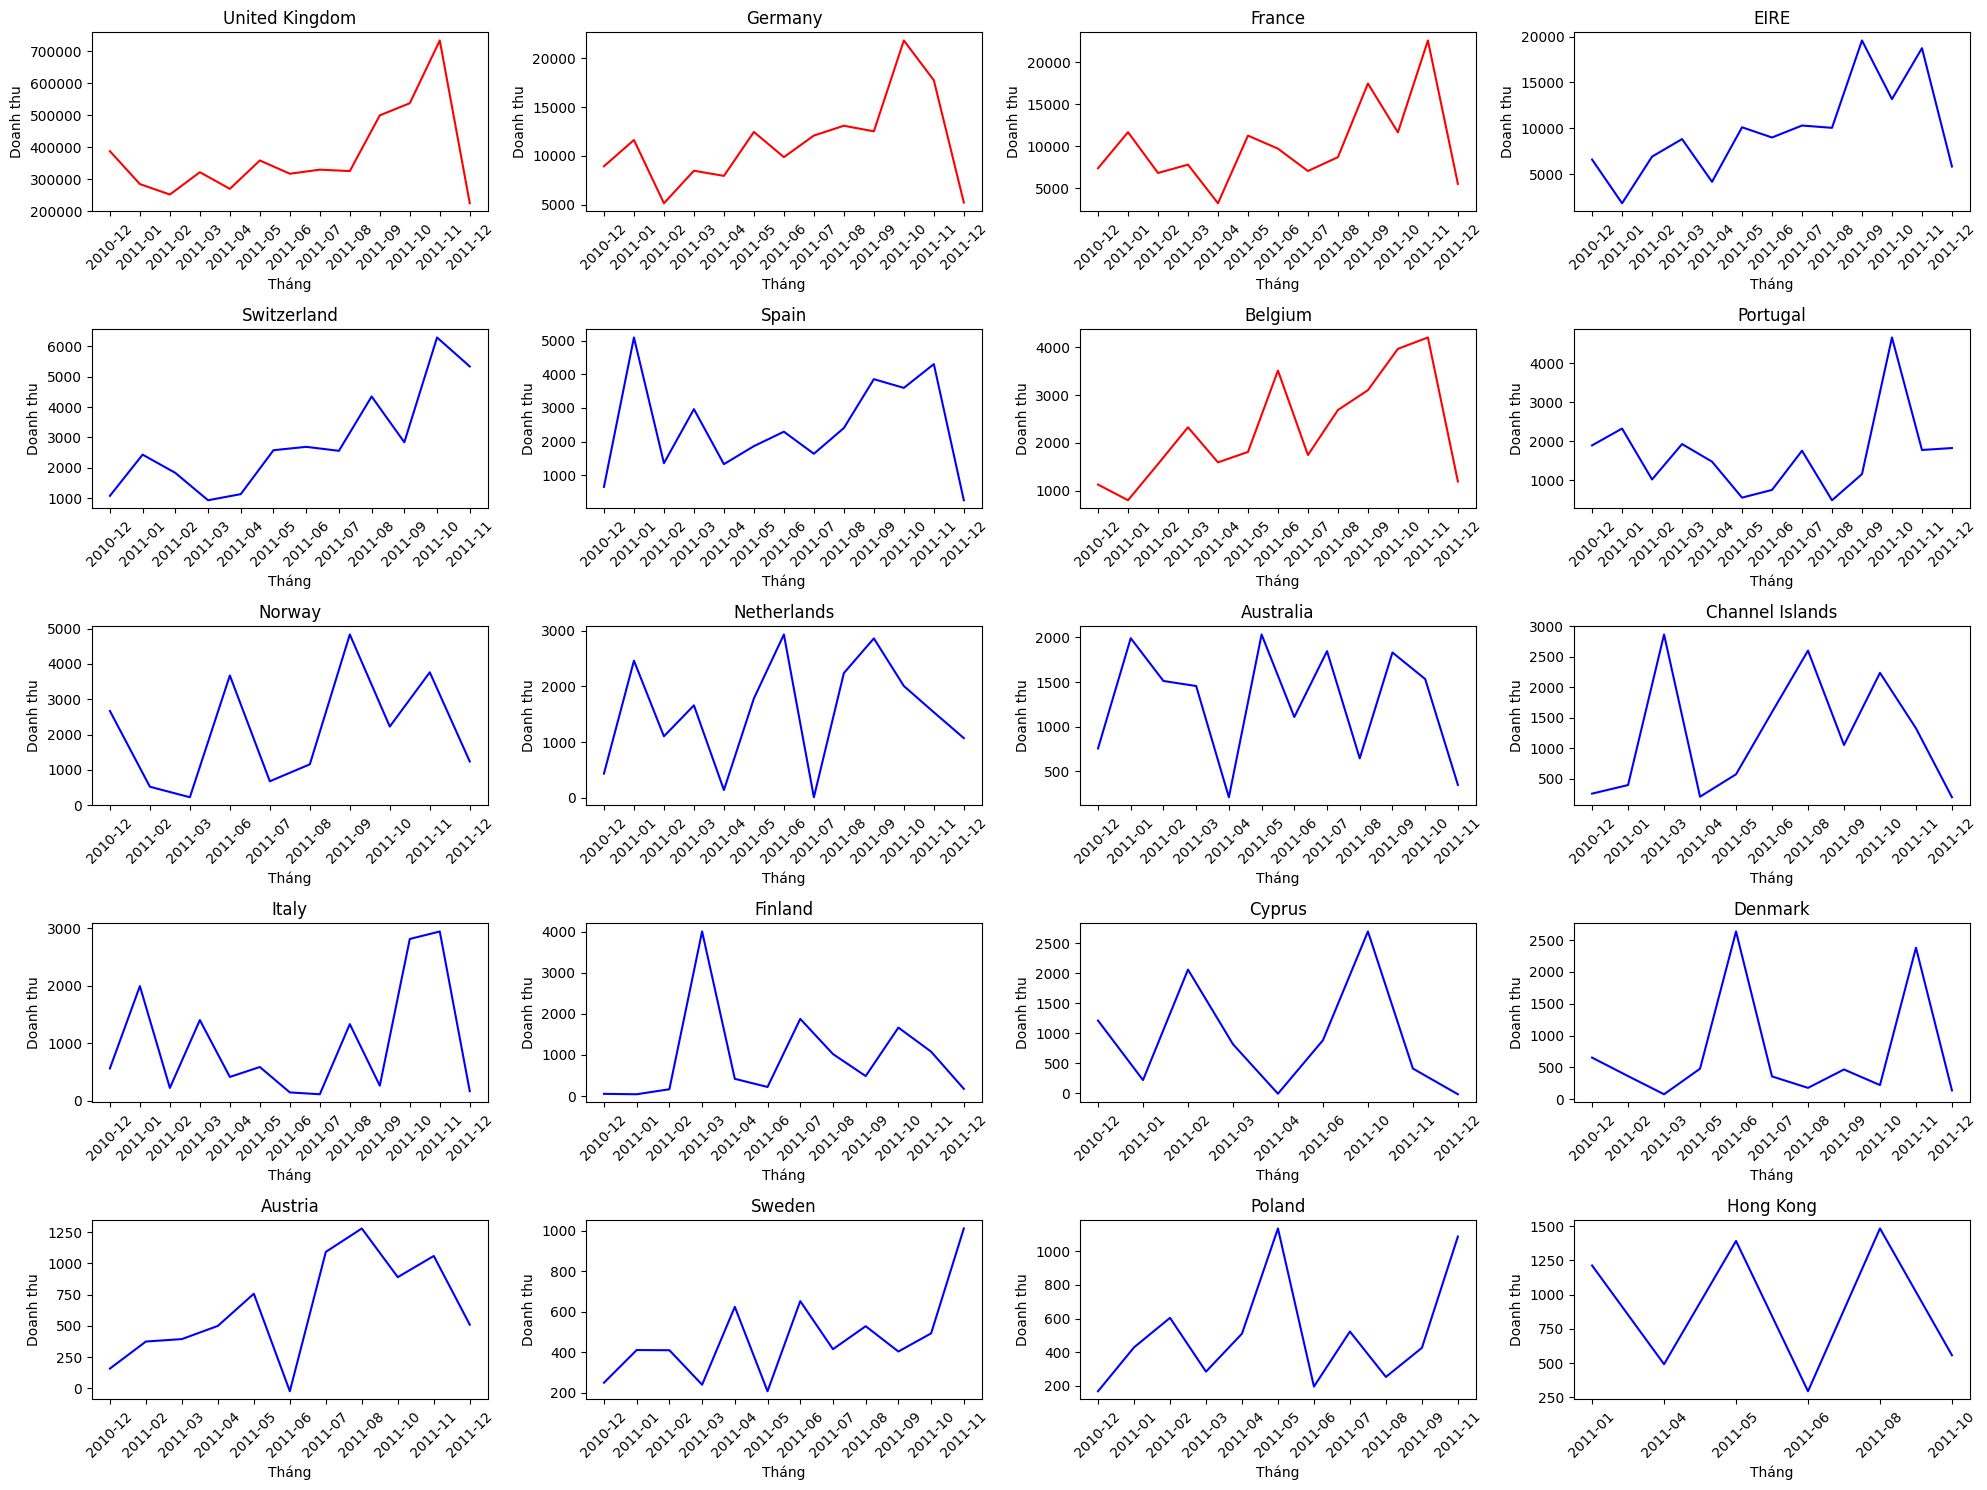

In [35]:
# Lấy ra top 20 quốc gia có doanh thu cao nhất
top20_countries = df_sale.groupby('Country')['revenue'].sum().sort_values(ascending=False).head(20).index.tolist()

# Tạo subplot 5 hàng 4 cột
fig, axs = plt.subplots(5, 4, figsize=(20, 15))

# Vẽ biểu đồ cho từng quốc gia
for i, country in enumerate(top20_countries):
    row = i // 4
    col = i % 4
    df_country = df_sale[df_sale['Country'] == country]
    revenue_by_month = df_country.groupby('year_month')['revenue'].sum()
    if country in ['United Kingdom', 'Germany', 'France', 'Belgium']:
        axs[row, col].plot(revenue_by_month.index, revenue_by_month.values, color='red')
    else:
        axs[row, col].plot(revenue_by_month.index, revenue_by_month.values, color='blue')

    axs[row, col].set_xlabel('Tháng')
    axs[row, col].set_ylabel('Doanh thu')
    axs[row, col].set_title(country)
    axs[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Xét theo xu hướng tăng trưởng thì các quốc gia như Anh, Pháp, Đức, Thụy Sĩ, Bỉ là những quốc gia tăng trưởng nhanh => cần nghiên cứu và mở rộng quy mô ở những thị trường này

#### 2.4 Phân tích số bán theo từng sản phẩm

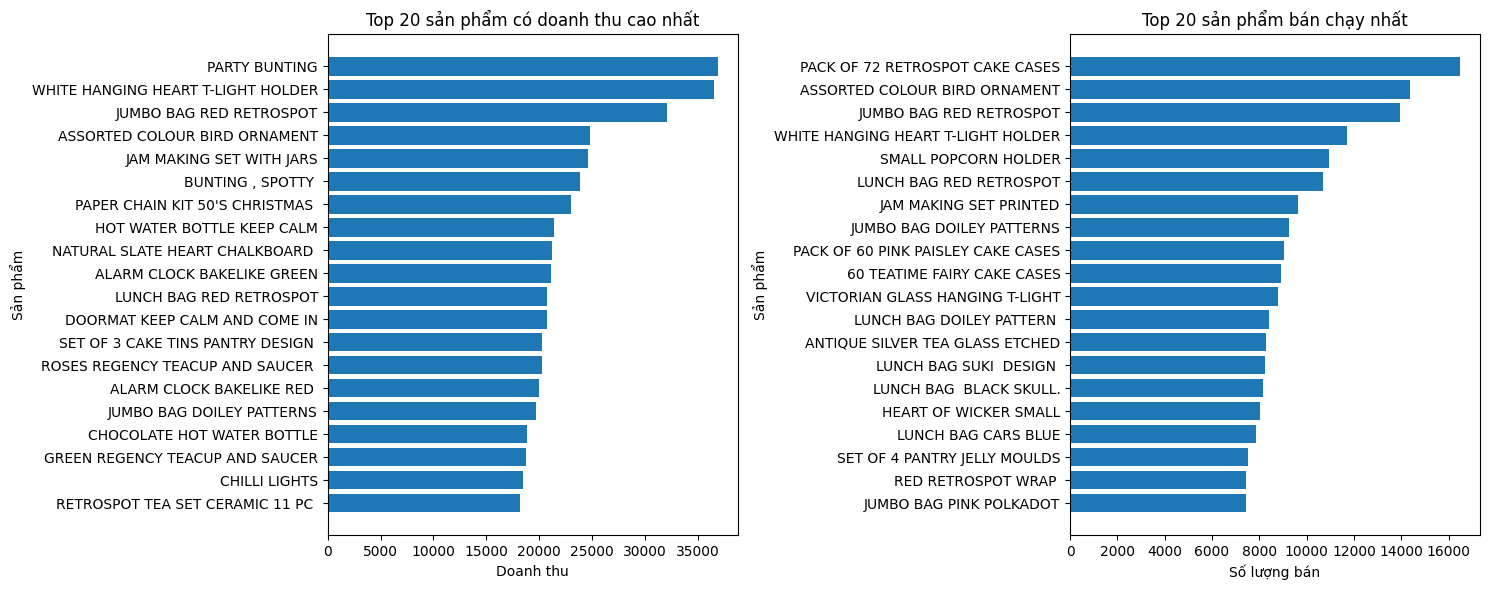

In [36]:
# Tạo subplot 1 hàng 2 cột
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Biểu đồ 1: Top 20 sản phẩm có doanh thu cao nhất
top20_revenue_products = df_sale.groupby('Description')['revenue'].sum().sort_values(ascending=False).head(20).sort_values()
axs[0].barh(top20_revenue_products.index, top20_revenue_products.values)
axs[0].set_xlabel('Doanh thu')
axs[0].set_ylabel('Sản phẩm')
axs[0].set_title('Top 20 sản phẩm có doanh thu cao nhất')

# Biểu đồ 2: Top 20 sản phẩm bán chạy nhất
top20_selling_products = df_sale.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(20).sort_values()
axs[1].barh(top20_selling_products.index, top20_selling_products.values)
axs[1].set_xlabel('Số lượng bán')
axs[1].set_ylabel('Sản phẩm')
axs[1].set_title('Top 20 sản phẩm bán chạy nhất')

plt.tight_layout()
plt.show()


Theo doanh thu thì sản phẩm Dotcom postage và Regency cakestand 3 tier có số doanh số cao hơn hẳn phần còn lại

Theo số lượng bán thì Small popcorn lại có số bán lớn

In [37]:
# Top sản phẩm hay được mua cùng nhau nhất

from itertools import combinations
import collections

# Tạo ra danh sách các sản phẩm được mua cùng nhau trong mỗi đơn hàng
orders = df_sale.groupby('InvoiceNo')['Description'].apply(list)

# Tạo ra danh sách tất cả các cặp sản phẩm được mua cùng nhau
pairs = []
for order in orders:
  for pair in combinations(order, 2):
    pairs.append(pair)

# Đếm số lần xuất hiện của mỗi cặp sản phẩm
pair_counts = collections.Counter(pairs)

# Lấy ra top 20 cặp sản phẩm được mua cùng nhau nhiều nhất
top20_pairs = pair_counts.most_common(20)

for pair, count in top20_pairs:
  print(f"{pair}: {count}")


('JUMBO BAG PINK POLKADOT', 'JUMBO BAG RED RETROSPOT'): 488
('GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER '): 480
('JUMBO SHOPPER VINTAGE RED PAISLEY', 'JUMBO BAG RED RETROSPOT'): 432
('JUMBO STORAGE BAG SUKI', 'JUMBO BAG RED RETROSPOT'): 412
('LUNCH BAG RED RETROSPOT', 'LUNCH BAG  BLACK SKULL.'): 394
('GREEN REGENCY TEACUP AND SAUCER', 'PINK REGENCY TEACUP AND SAUCER'): 392
('ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE RED '): 371
('JUMBO BAG RED RETROSPOT', 'JUMBO  BAG BAROQUE BLACK WHITE'): 365
('PINK REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER '): 362
('JUMBO BAG APPLES', 'JUMBO BAG RED RETROSPOT'): 350
('LUNCH BAG RED RETROSPOT', 'LUNCH BAG PINK POLKADOT'): 340
('LUNCH BAG RED RETROSPOT', 'LUNCH BAG SUKI  DESIGN '): 340
('JUMBO STORAGE BAG SUKI', 'JUMBO SHOPPER VINTAGE RED PAISLEY'): 338
('JAM MAKING SET WITH JARS', 'JAM MAKING SET PRINTED'): 333
('SPACEBOY LUNCH BOX ', 'DOLLY GIRL LUNCH BOX'): 325
('JUMBO BAG DOILEY PATTERNS', 'JUMBO

#### 2.5 RFM Analysis

In [43]:
most_recent_date = df_sale.InvoiceDate.max()
rfm_data = df_sale.groupby(by='CustomerID').aggregate({
    'InvoiceDate' : lambda x: (most_recent_date - x.max()).days,
    'InvoiceNo' : lambda x: len(x),
    'revenue' : lambda x: sum(x)
})
rfm_data.columns = ['Recency', 'Frequency', 'Monetary value']
# qcut() function allows to set the value its quantile in the distribution of a feature.
R_quantiles = pd.qcut(rfm_data['Recency'], 3, [1, 2, 3])
F_quantiles = pd.qcut(rfm_data['Frequency'], 3, [3, 2, 1])
M_quantiles = pd.qcut(rfm_data['Monetary value'], 3, [3, 2, 1])
rfm_data['RFM label'] = R_quantiles.astype(str) + '-' + F_quantiles.astype(str) + '-' + M_quantiles.astype(str)
rfm_data.head()

,Recency,Frequency,Monetary value,RFM label
CustomerID,,,,
12347.0,1,167,3412.53,1-1-1
12348.0,248,6,90.20,3-3-3
12349.0,18,64,1197.15,1-2-1
12350.0,309,16,294.40,3-3-2
12352.0,35,78,1112.11,2-1-1


In [51]:
# Function to plot graphs
def plot_bar(y, x, figsize, invert=True, title=''):
    # Nice giudlines are available at: https://matplotlib.org/stable/gallery/statistics/barchart_demo.html
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel('RFM label', fontsize=20)
    ax.set_xlabel('Số lượng KH', fontsize=20)
    # Need to create a variable to then pass to the bar_label()
    bars = ax.barh(y, x, align='center')
    # Axis labels font
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(18)
    for label in ax.yaxis.get_ticklabels():
        label.set_fontsize(18)
    # Remove axes spines
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)
    # Add x, y gridlines
    ax.grid(visible=True, color='grey',
            linestyle='-.', linewidth=0.5,
            alpha=0.7)
    # Sort bars in descending order
    if (invert==True):
        ax.invert_yaxis()
    # Add bar labels
    ax.bar_label(bars,
                 padding=5,
                 fontsize=16,
                 color='grey',
                 fontweight='bold')

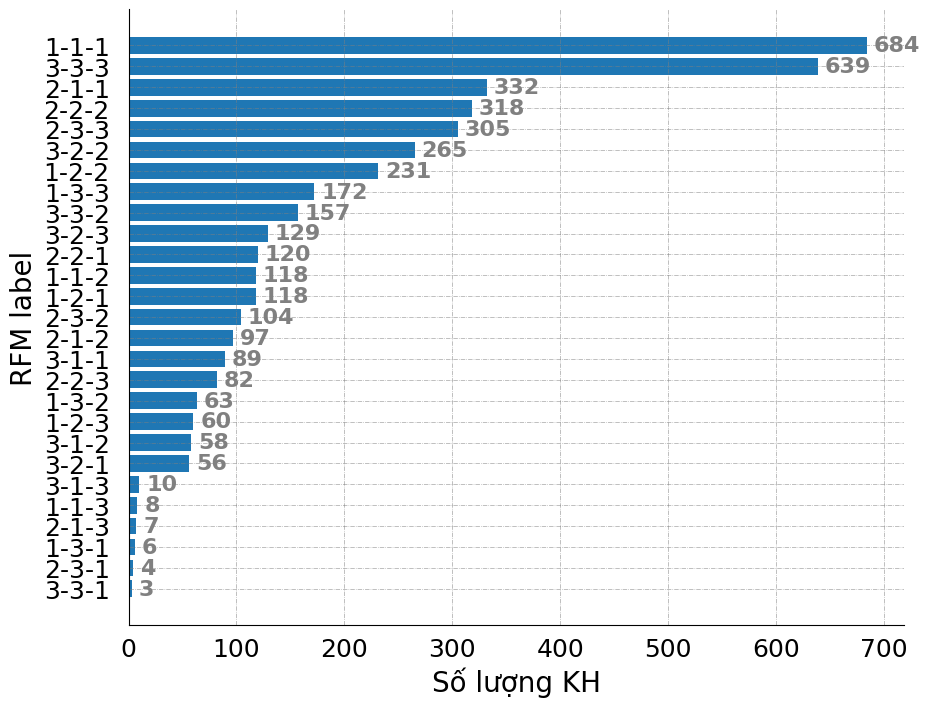

In [52]:
plot_bar(y = rfm_data['RFM label'].value_counts().index,
        x = rfm_data['RFM label'].value_counts().values,
        figsize=(10,8),
        invert=True,)

Từ biểu đồ trên có thể thấy:
- Nhãn 1-1-1 và 3-3-3 chiếm tỷ lệ cao nhất:
    + Nhóm 1-1-1 có thể đại diện cho những khách hàng tốt nhất (tần suất mua hàng cao, giá trị giao dịch lớn và gần đây)
    + trong khi nhóm 3-3-3 có thể là những khách hàng ít hoạt động (mua hàng không thường xuyên, giá trị giao dịch thấp và giao dịch gần đây ít).

    => Doanh nghiệp nên tập trung vào việc duy trì và cải thiện trải nghiệm của các nhóm khách hàng có giá trị cao (nhóm 1-1-1) và tìm cách kích hoạt lại các khách hàng trong nhóm ít tương tác (nhóm 3-3-3).


- Ví dụ nhóm 1-1-1: Nhóm khách hàng này có thể sử dụng các chương trình tiếp thị dành riêng => với nhóm này có thể dành tặng họ những phiếu giảm giá khi họ giới thiệu người thân mua hàng, áp dụng cho 1 số mặt hàng mà trước đây họ đã từng mua nhiều lần. Như vậy vừa giữ thể hiện sự quan tâm đến họ mà vừa có thể thu hút thêm những khách hàg mới
- Nhóm 3-3-3 cũng khá nhiều: cho thấy rất nhiều khách chỉ đến mua 1 lần và rời bỏ. Vì vậy với các khách hàng mới có hệ số là 3-x-x thì cần có ngay chương trình tặng voucher áp dụng cho lần mua thứ 2

- Vân vân,...